<a href="https://colab.research.google.com/github/zurkin1/Machine-Learning/blob/master/Ex5_Deep_Learning_for_Machine_Perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><b>Deep Learning for Machine Perception</b></center></h1>
<h3><center>Exercise 5</center></h3>

Your Names:  
<font color='red'>
FirstName1 LastName1, 123456789  
FirstName2 LastName2, 987654321  
</font>


____________

In this exercise we will:
1. Implement the SimCLR algorithm and train a model on ImageNet-5.
2. Implement a GAN and train it.
3. Generate new mnist samples!

**Instructions:**
- Create a copy of this notebook and implement your code in it.
- Make sure you don't leave empty cells or empty answers.
- You should not change the code that we have provided to you.
- When you finish the assignment, download the *notebook* and submit it to the [**"submit"**](https://submit.cs.biu.ac.il/cgi-bin/welcome.cgi) system. 
To Download the notebook go to **"File"** -> **"Download .ipynb"**.  
- For questions regarding this assignment, email ‫biu.cs.896874@gmail.com‬  

### **1. Setup**
Before running code on Colab:
- Go to "Runtime" -> "Change runtime type", and make sure to choose "GPU" for Hardware accelerator.
- Check your Python version at the command line by running "!python --version". It should be Python 3.6 by default.

In [ ]:
# check python version
!python --version

### **2. Self Supervised Learning**

In this section we are going to implement the simCLR loss and train a model on a small version of ImageNet called ImageNet-5, which has only 5 categories instead of 1000.

[simCLR](https://arxiv.org/pdf/2002.05709.pdf)  (A Simple Framework for Contrastive Learning of Visual Representations) was proposed by Chen et al in 2020 for the "Unsupervised representation learning" task.
The goal of this task is to learn a good representation of the data without labels!  
The authors present a simple self-supervised framework for contrastive learning of visual representations.

Some basic concepts before we start:

**Self-supervised learning:**   
Self-supervised learning is a learning technique using supervised learning with unlabeled data. The idea is to create labels for another task (called pretext task) that are easy to create automatically and are informative about the main task .

**Contrastive Learning:**  
Contrastive learning is the idea of learning representations by enforcing a similar representation of elements that are known to be semantically equivalent, and push away representations of dissimilar elements.

**SimCLR:**  
The idea of SimCLR framework is simple:  
An image is taken and random transformations are applied to it to get a pair of two augmented images 
$x_i$ and $x_j$. Each image in that pair is passed through an encoder to get representations. Then a non-linear fully connected layer is applied to get representations z. The task is to maximize the similarity between these two representations 
$z_i$ and $z_j$ for the same image.


<center>
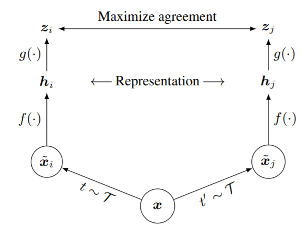

Go over the [paper](https://arxiv.org/pdf/2002.05709.pdf) and this [tutorial](https://amitness.com/2020/03/illustrated-simclr/) to get a better idea of how simCLR works and the intuition behind it.

#### **2.1 Preparations**

We start by downloading the data and creating a custom pytorch dataset.

In [ ]:
# download imagenet-5
!git clone https://github.com/thunderInfy/imagenet-5-categories.git

In [ ]:
import numpy as np
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from PIL import Image
import os

In [ ]:
class ImageNetFive(Dataset):
  def __init__(self, root_dir, transform, augment=True):
    self.root_dir = root_dir
    self.augment = augment
    self.transform = transform
    self.class_mappings = {'car': 0, 'dog': 1, 'elephant': 2, 'cat': 3, 'airplane': 4}
    imgs_path = np.array(list(sorted(os.listdir(self.root_dir))))
    labels = np.array([self.class_mappings[x.split('_')[0]] for x in imgs_path])
    # reduce number of samples per class
    self.imgs_path = []
    self.labels = []
    for l in np.unique(labels):
      idx = np.where(labels == l)[0][:15].astype(int)
      self.imgs_path += imgs_path[idx].tolist()
      self.labels += labels[idx].tolist()

  def __len__(self):
    return len(self.imgs_path)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()
    # load image from disk
    img = Image.open(os.path.join(self.root_dir, self.imgs_path[idx]))
    # get its label
    label = self.labels[idx]

    if self.augment:
      # training mode - create two augmentations
      aug_image1 = self.transform(img)
      aug_image2 = self.transform(img)
      sample = {'image1': aug_image1, 'image2': aug_image2, 'label': label}
    else:
      # test mode - no need for augmentations
      image = self.transform(img)
      sample = {'image': image, 'label': label}

    return sample

#### **2.2 Augmentations**

Before we dive into implementing the loss itself, let's implement a crucial part of the algorithm: Augmenting Images.

During training, we are going to pick an image from the dataset and apply transformations to it to create two augmented images.
We would later want the features of those two images to be similar in the embedding space but different from other images in the data.

To apply transformations to an image we can use ```torchvision.transforms```.  
Go over the code below and see how the transformation for train images (```transform_train```) and test images (```transform_test```) are defined.

In [ ]:
# transformation on train images
transform_train = transforms.Compose(
    [
      transforms.Resize((250, 250)), # resize image
      transforms.RandomHorizontalFlip(p=0.5), # AUGMENTATION: Random Horizontal Flip
      transforms.RandomResizedCrop(224), # AUGMENTATION: Random Cropping
      transforms.ToTensor(), # numpy array to tensor
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize the image
     ])

# basic transformation on test images
transform_test = transforms.Compose(
    [
      transforms.Resize((224, 224)), # resize image
      transforms.ToTensor(), # numpy array to tensor
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize the image
    ])

Note that here, we have declared two types of ```transforms```: ```transform_train``` and ```transform_test```.  
During training we are going to load train images and apply ```transform_train``` on them **twice** (meaning, creating two image augmentations). During evaluation, we don't want to create augmentations, so only basic transformations are applied (resizing and normalizing, which should be done to every image in the data). For that we have ```transform_test```.

In the above ```transform_train``` we apply only two simple  augmentations to an image: ```RandomHorizontalFlip``` and ```RandomResizedCrop```. ```RandomHorizontalFlip``` flips the image randomly with a given probability (in our case 50%), while ```RandomResizedCrop``` crops the image to random size and aspect ratio.

See the official documentation for many more: [Pytorch Transforms](https://pytorch.org/docs/stable/torchvision/transforms.html).

Copy ```transform_train``` from above and add at least two more types of augmentations. You can use pytorch transforms or implement augmentations yourself.

In [ ]:
######################
### YOUR CODE HERE ###
###################### 
# transform_train = ...

We can now create datasets and dataloaders

In [ ]:
# train-set with augmentations
train_dataset = ImageNetFive(root_dir="imagenet-5-categories/train", transform=transform_train, augment=True)
# set train loader with augmentations
train_loader = DataLoader(train_dataset, batch_size=75, shuffle=True)

# train set without augmentation
raw_train_dataset = ImageNetFive(root_dir="imagenet-5-categories/train", transform=transform_test, augment=False)
# set train loader without augmentation
raw_train_loader = DataLoader(raw_train_dataset, batch_size=50, shuffle=True)

# test-set
test_dataset = ImageNetFive(root_dir="imagenet-5-categories/test", transform=transform_test, augment=False)
# test loader
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

Let's see that it works as expected. We take a sample from the ```raw_train_dataset``` (the dataset where no augmentations are applied) and from ```train_dataset``` (dataset with augmentations).

In [ ]:
# take the first sample from raw_train_set
first_raw_sample = raw_train_dataset[0]

# take one sample (=two augmentations) from train_dataset
first_aug_sample = train_dataset[0]
# the result is a dicrtionary, so print its keys
print(first_aug_sample.keys())

From the output we can see that a sample of the train set with augmentations consists of two images: ```image1``` and ```image2``` which are both augmentations of an original ImageNet image.

Let's visualize them:

In [ ]:
# first visualize original image
plt.imshow(first_raw_sample['image'].permute(1, 2, 0))

In [ ]:
# now visualize the two augmentations
plt.subplot(1,2,1)
plt.imshow(first_aug_sample['image1'].permute(1, 2, 0))
plt.subplot(1,2,2)
plt.imshow(first_aug_sample['image2'].permute(1, 2, 0))

You should be able to see two *similar* images that were created from an original image.

#### **2.4 Contrastive Loss**



Now we can implement the loss function.
SimCLR uses a contrastive loss called "NT-Xent loss" (Normalized Temperature-Scaled Cross-Entropy Loss)

The loss is defined for a pair of images as:

$$l_{i,j} = - \log{\frac{e^{sim(z_i,z_j)/\tau}}{\sum_{k=1}^{2N}{I_{[k\not=i]}e^{sim(z_i,z_k)/\tau}}}}$$


where:
- $z_i$ and $z_j$ are 1d representations (features) vectors of an augmented image $i$ and an augmented image $j$ respectively.
- 2N is the batch size (N for the first type of augmentations + N for the second type of augmentations).
- $sim(x,y)$ is the similarity function between two vectors **x** and **y**.
- $\tau$ is a temperature parameter used to scale the value returned by the similarity function.

The loss for one single batch is then the contrastive loss between every two instances in the batch:

$$ L = \frac{1}{2N} \sum_{i=1}^{2N}{l(2i-1, 2i) + l(2i,2i-1)}  \quad \mathbf{(Eq. 1)}$$

The similarity function $sim(x,y)$ used in SimCLR is the **cosine similarity** between x and y. Which is simply the dot product of two normalized vectors.

$$ sim(x,y) = \frac{x^T \cdot y}{||x||||y||} \quad \mathbf{(Eq. 2)}$$

Implement the function ```cosine_similarity``` and ```contrastive_loss``` below. Don't forget to use torch functions so we can later do backpropagation and pass gradients

**IMPORTANT:** You are **not** allowed to use ```nn.CosineSimilarity```, ```nn.CrossEntropyLoss``` or ```nn.Softmax```. You must follow the comments we left for you in the cell. 
The commets should help you implement the loss efficiently and understand how it works.

For numerical stability, use this log rule:

$$ \log{\frac{e^x}{\sum_y{e^y}}} = \log(e^x) - \log(\sum_y{e^y}) = e^x - \log(\sum_y{e^y}) \quad \mathbf{(Eq. 3)}$$

<font color='green'><b>
5 Bonus points will be given for students that implement the functions below without loops!
</b></font>

In [ ]:
def pairwise_cosine_sim(X, Y):
  '''
  General implementation of Eq (2).
  The function calculates the cosine similarity between each pair in X and Y:
  X and Y are two batches of vectors and the function calculates the cosine similarity
  between each pair and return a matrix with shape [|x|,|y|] where cell [i,j] is
  the cosine similarity between X[i,:] and Y[j,:].
  '''
  ######################
  ### YOUR CODE HERE ###
  ###################### 
  # Hint: Do not forget to normalize the vectors!
  # return ..
  ######################

def contrastive_loss(aug1_batch, aug2_batch, temperature=0.07):
  '''
  Implementation of Eq (1).
  The function calculates the contrastive loss for the given image augmentation
  batches (aug1_batch and aug2_batch).
  '''
  batch_size = aug1_batch.shape[0]
  # 1. concat both batches to one big batch. 
  #    (Result shape should be: [2*batch_size, feat_dim])


  # 2. compute similarity between each pair in representations matrix.
  #    use ```pairwise_cosine_sim``` funciton.
  #    (Result shape should be: [2*batch_size, 2*batch_size])


  # 3. divide values by temperature
  #    (Result shape should be: [2*batch_size, 2*batch_size])


  # 4. calculate the denominator in the loss:
  #    4.1.  apply exponent on all values
  #          (Result shape should be: [2*batch_size, 2*batch_size])

  #    4.2.  zero out similarities between samples to themselfs (remove the diagonal)
  #          and calculate the sum for each row in the matrix
  #          (Result shape should be: [2*batch_size])


  # 5. calculate the log probabilities
  #   5.1. log rule [Eq (3)]: # log(e^x/sum(y)) = x - log(sum(y))
  #        (Result shape should be: [2*batch_size,2*batch_size])

  #   5.2. take only the positives: 
  #        cells where the samples should be similar we want to maximize the similarity between them
  #        (Result shape should be: [2*batch_size])

  #  6. multiply by -1 and compute the mean (sum of log probabilities/(2*batch_size))
  #    (Result shape should be: Scalar)

  return loss

Test your implementation with the dummy example below:

In [ ]:
batch_1 = torch.tensor([[-0.83483301, -0.16904167, 0.52390721],[ 0.70374682, -0.18682394, -0.68544673]])
batch_2 = torch.tensor([[-0.83455951, -0.16862266, 0.52447767],[ 0.76652431,  0.61500886,  0.18494479]])
contrastive_loss(batch_1, batch_2, temperature=1)

If you implemented it correctly, the loss would be ```0.4068```.

**Q1:**   
What is the goal of the temperature parameter $\tau$? How does it affect the loss?  

**A1:**  
<font color='red'>
YOUR ANSWER HERE!  
</font>



**Q2:**   
**a.** What will be the value of the loss for a batch with 2N ***identical*** samples? Find a mathematical formulation.  
**b.** In that case, will different temperature values change the loss?

**A2**:  
<font color='red'>
YOUR ANSWER HERE!  
</font>


**Q3:** How does the batch size affect the contrastive loss? Is large batch size better than small batch size when training a model with contrastive loss?

Hint: Note that the loss calculates the exponent of the cosine similarity between each pair in the batch.

**A3**:  
<font color='red'>
YOUR ANSWER HERE!  
</font>


#### **2.5 Model**

The model in the SimCLR framework is composed of two parts:

1. *Base Encoder* $f(\cdot)$ - A convolutional neural network without a classifier. Its goal is to extract features (image representations) for each augmented image that is passed through it.  
Inputs: Augmented images $x_i$ and $x_j$   
Outputs: $h_i$ and $h_j$ - vector representations of the two images.

2. *Projection Head* $g(\cdot)$ - A simple fully connected neural network that takes the output of the base encoder and learns to map them to final image representations.    
Inputs: $h_i$ and $h_j$  
Outputs: $z_i$ and $z_j$.

See the diagram below for visualization.

Note that the vectors $z_i$ and $z_j$ have lower dimensions than $h_i$ and $h_j$.

<center>
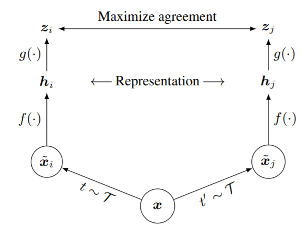

Create a resnet18 instance (using torchvision) as the base encoder, and replace the classifier head with a projection head.  
The projection head architecture is as follows:

A **fully connected layer** with 100 units, a **relu activation**, another **fully connected layer** with 40 units, a **relu activation** and finally an **output layer** with 20 units (so the final features will have dimention=20).

In [ ]:
def create_simclr_model():
  # create new resnet18 as the base encoder
  simclr_model = torchvision.models.resnet18(pretrained=False)
  # change its classifier to a projection head
  ######################
  ### YOUR CODE HERE ###
  ###################### 
  
  ######################
  return simclr_model

Let's implement a function for creating an SGD optimizer for a given model.

In [ ]:
def create_optimizer(model, lr, momentum=0.9):
  return optim.SGD(model.parameters(), lr=lr, momentum=momentum)

#### **2.6 Training**

We can now finally train the model on the data.   
Implement the train function below. Use the ```contrastive loss``` you implemented above.

In [ ]:
def self_supervised_training(model, optimizer, train_dataloader, temperature=0.07, 
                             num_epochs=10, print_freq=30, device="cuda"):
  # move model to device
  model = model.to(device)

  for epoch in range(num_epochs):
    model.train()
    for (idx, aug_batch) in enumerate(train_dataloader):
        ######################
        ### YOUR CODE HERE ###
        ###################### 

        ######################
        loss_value = loss.cpu().data.item()

    if epoch % print_freq == 0:
      print(f"Epoch {epoch}, Contrastive loss={loss_value}")

  return model

In [ ]:
# hyper params
num_epochs = 30
lr=0.003

# Create new instance of the model
simclr_model = create_simclr_model()
# Create optimizer
simclr_opt = create_optimizer(simclr_model, lr=lr, momentum=0.9)
# Train the model
simclr_model = self_supervised_training(simclr_model, simclr_opt, train_loader,
                                        num_epochs=num_epochs, print_freq=5, device="cuda")


You should see the loss slowly decreasing at every epoch.

#### **2.7 Visualizations**

So we trained the model for 10 epochs, and hopefully it now has good representations for each sample. That is, images from the same class are close to each other in the feature space.

We would like to visualize the features. The problem is that the features are high dimensional vectors, and we can't plot vectors with dim > 3.  
What can we do?
We can use T-SNE!
t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space.

Let's visualize the train and test features using T-SNE:
1. Using the trained model, extract the features from both the raw train set (using ```raw_train_loader``` and from the test set (using ```test_loader```).
2. With T-SNE, reduce the dimension from 20 to 2.
3. Use matplotlib to plot **two separate** scatter plots - one for each set. Color samples with the same labels with the same color! ([This](https://stackoverflow.com/questions/47006268/matplotlib-scatter-plot-with-color-label-and-legend-specified-by-c-option) might help you. )

You can use [sklearn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) for T-SNE.

In [ ]:
# set model in eval mode
_ = simclr_model.eval()

In [ ]:
feat_dim = 20

def extract_features_and_labels(model, dataloader):
  # create empty placeholders
  features = torch.empty((0, feat_dim))
  labels = torch.empty(0, dtype=torch.long)
  for (_, batch) in enumerate(dataloader):
    image = batch['image']
    curr_labels = batch['label']
    curr_feats = model(image.to("cuda"))
    features = torch.cat((features, curr_feats.cpu().detach()))
    labels = torch.cat((labels, curr_labels))
  return features.numpy(), labels.numpy()

# 1.1 Extract train features
train_features, train_labels = extract_features_and_labels(simclr_model, raw_train_loader)

# 1.2 Extract test features
test_features, test_labels = extract_features_and_labels(simclr_model, test_loader)

In [ ]:
# 2. Reduce dimention with t-sne (from 20-d vectors to 2-d vectors)
from sklearn.manifold import TSNE
######################
### YOUR CODE HERE ###
###################### 

######################

In [ ]:
# 3. Plot the train and test features on a 2d plot using the embedded vectors extracted from TSNE
# Do not forget to color samples with the same color if they have the same label
# PLOT EACH SET ON A DIFFERENT PLOT
classes = np.unique(train_labels)
plt.rcParams["figure.figsize"] = (13,5)
######################
### YOUR CODE HERE ###
######################
# first figure for train set features visualization

# second figure for test set features visualization

######################

If you implemented everything correctly, you should see that features from the same class (same color) are close to each other in the feature space.

### **3. Generative Adversarial Network (GAN)**

In this section, we are going to implement a generative adversarial network (GAN), train it on the MNIST dataset, and generate new synthetic handwritten images (new mnist samples).



#### **3.1 Preparations**

[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) was introduces by Ian Goodfellow et al (Yoshua Bengio's lab) in 2014.  
GANs have become a popular research topic since then with many cool applications like [translating horses to zebras](https://junyanz.github.io/CycleGAN/), [creating deep fakes](https://www.youtube.com/watch?v=gLoI9hAX9dw) and [creating images of persons that do not exist](https://thispersondoesnotexist.com/).


We are going to implement a simple vanilla GAN on MNIST.  
The idea is simple: We have two networks, a Generator and a Discriminator. Both competing against each other. 

The Generator gets a random input (latent sample, $z$) and learns to generate a fake image in order to fool the discriminator. The discriminator sees real training data and a generator's fake data and try to identify which is real and which is fake.  

This way, if both models trained properly, the generator would create images that look like real data **from random noise**.  Usually, in the end, we are interested in generating only new images, so we can throw out the discriminator after training and use only the generator.



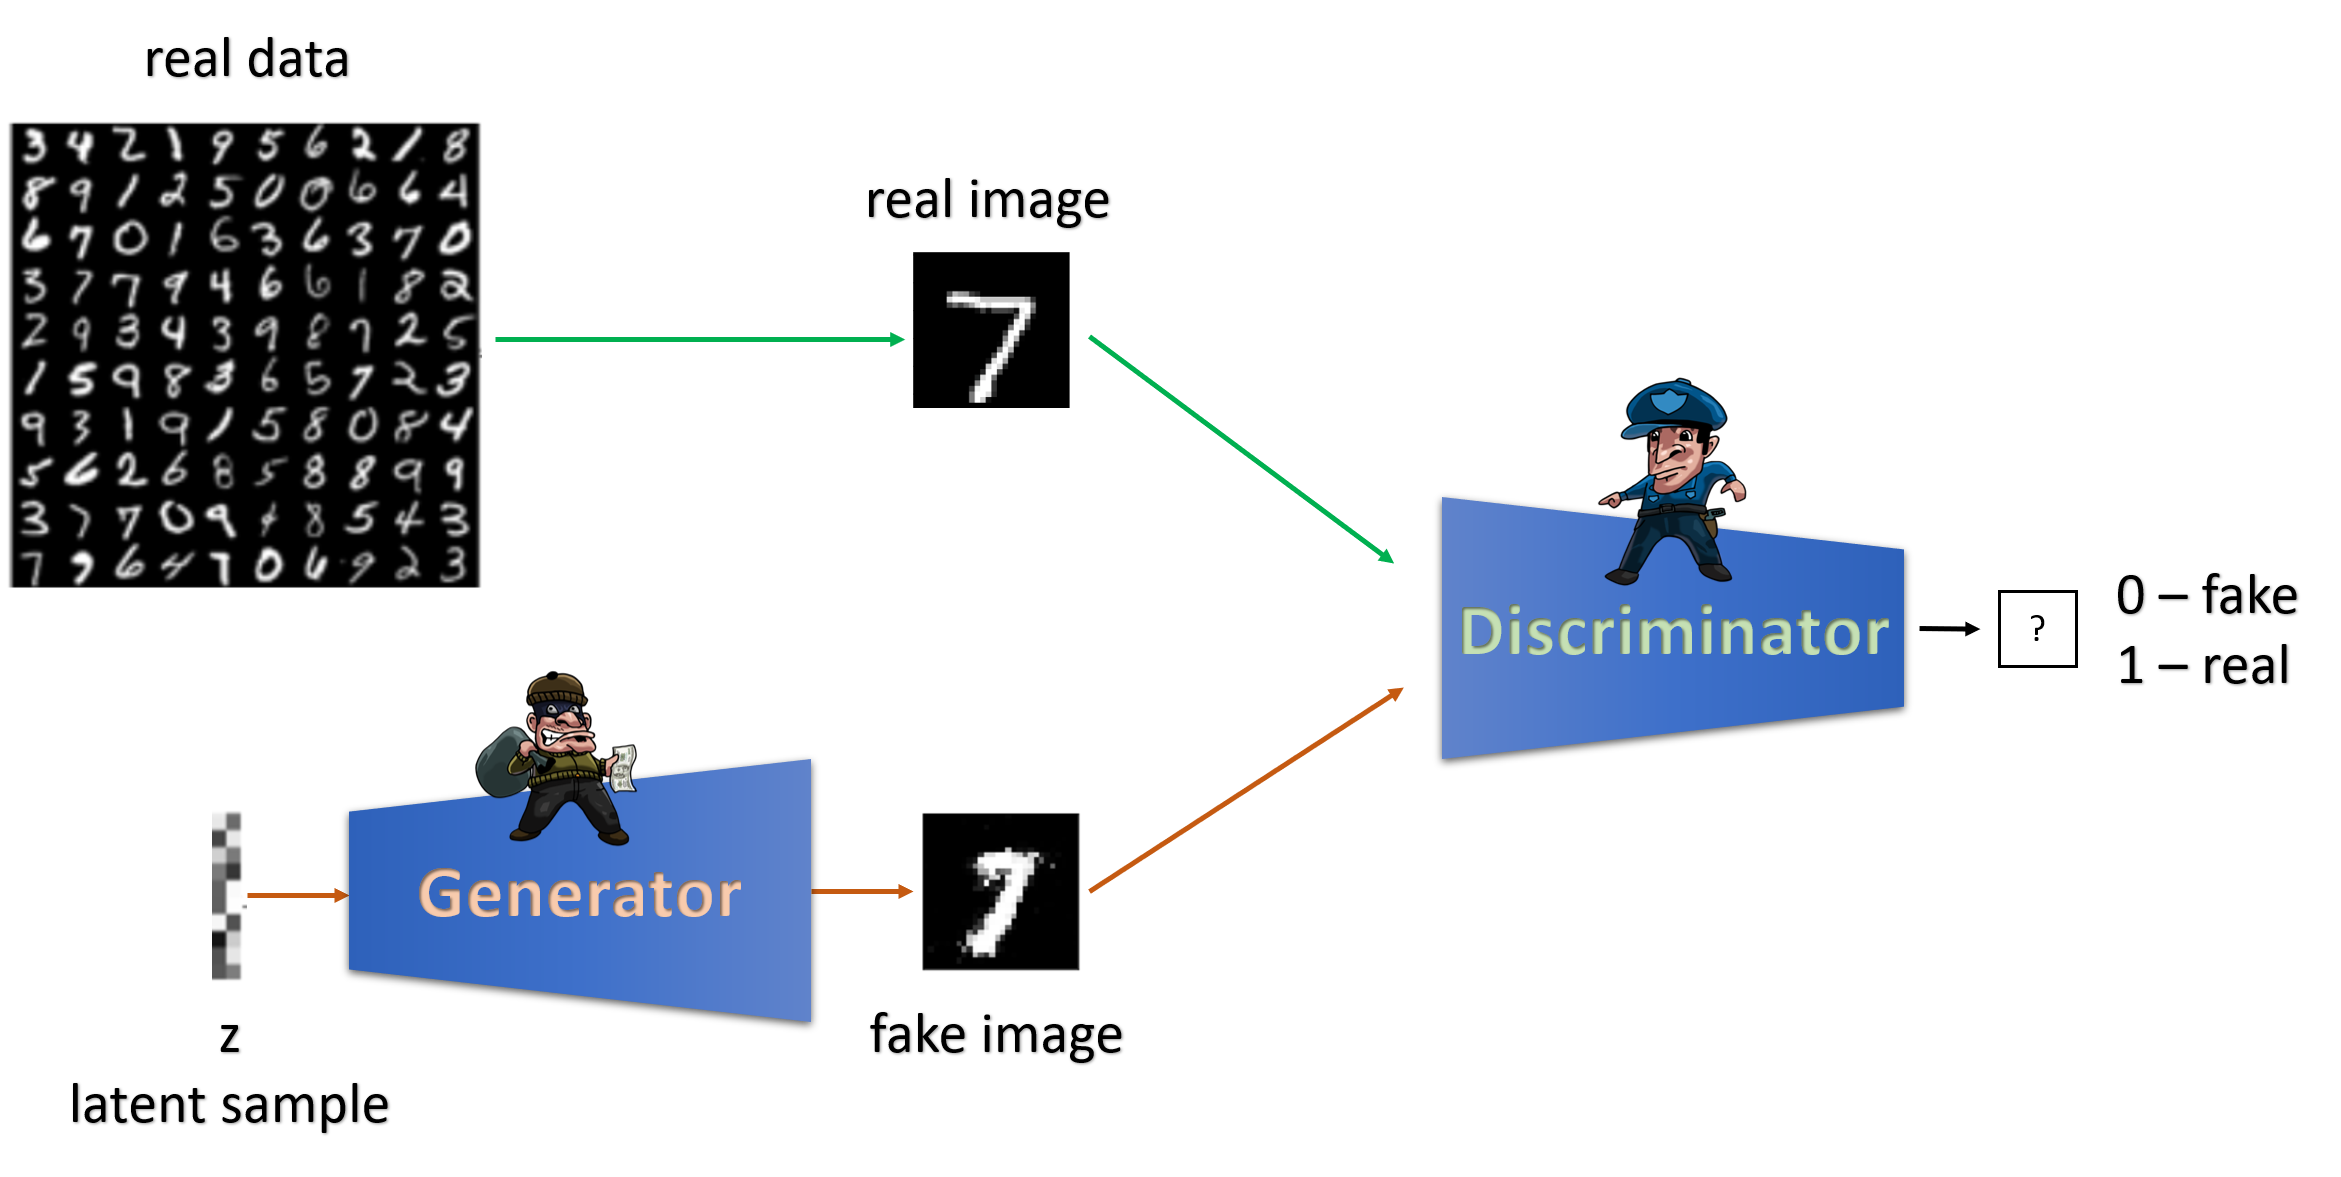

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Let's first download the data and create dataloaders.

In [ ]:
# batch size
batch_size = 64
# train set
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
# dataloader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

Let's print the shape of one image:

In [ ]:
print(train_data.data[0].shape)

Note that the size of each image is 28x28.  To make it easier for us, we are going to flatten each image to a 784-tensor. This way we can use simple neural networks instead of convolutional neural networks. (The generator is a neural network that outputs a 784-tensor and the discriminator is a neural network that gets a 784 tensor).

#### **3.2 Generator**

We can start by implementing the generator.  

The generator takes random latent vector $z$ and outputs a generated image $g$. Usually the latent vector is much smaller than the size of the vector $g$ (the image). To do that there should be more hidden layers at the end of the network compared to the beginning of the network (to get a small sized vector as input and output a big sized image (vector) as output).

We will create a simple generator with the following architecture:  
**|z| input units** (this is our latent vector $z$ with size |z|), a hidden layer with **$h$ units**, a **leaky relu activation** and a **dropout** layer. Then, a hidden layer with **2x$h$ units**, a **leaky relu activation** and a **dropout** layer. Then, another hidden layer with **4x$h$ units**, a **leaky relu** activation and a **dropout** layer. Finally, an output layer with **$|g|$ output units** and a **tanh activation**. 

Note that the generator looks like a simple neural network with four major changes:
- First, the number of hidden units grow from layer to layer ($h$ -> $2h$ -> $4h$).
- Second, we use a leaky relu activation instead of a simple relu. The reason is that we need to allow gradients to flow backward through the layer unimpeded which turns out to be common while training GANs. All leaky relu activations should have a negative slope of 0.2.  
- Third, we use the tanh activation. The generator has been found to perform better with $tanh$ for its output.
- Finally, we use dropout activations. It seems like dropout helps the training process of GANs and prevents the generator from overfitting. Use dropout rate of 0.3.





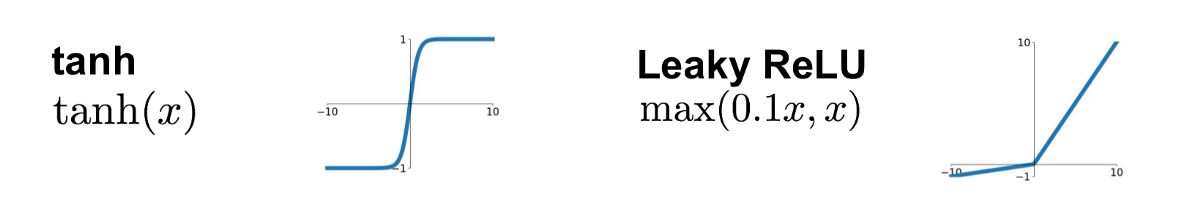

Implement the Generator class below.

In [ ]:
class Generator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Generator, self).__init__()
    ######################
    ### YOUR CODE HERE ###
    ######################
    # Declare layers for the model
    pass
    ######################

  def forward(self, x):
    ######################
    ### YOUR CODE HERE ###
    ###################### 
    # Forward pass through the network
    # out = ...
    ######################
    return out

Set hyper parameters:

In [ ]:
# generator hyper parameters
latent_vector_size = 100
first_hidden_size = 32
output_image_size = train_data.data[0].shape[0] * train_data.data[0].shape[1] #28*28=784

# creates a generator
generator = Generator(latent_vector_size, first_hidden_size, output_image_size)

In [ ]:
print(generator)

As we said before, the generator receives as input random latent vectors. Let's implement a function that generates such vectors:

In [ ]:
def create_latent_batch_vectors(batch_size, latent_vector_size, device):
  '''
  The function creates a random batch of latent vectors with random values 
  distributed uniformly between -1 and 1. 
  Finally, it moves the tensor to the given ```device``` (cpu or gpu).
  The output should have a shape of [batch_size, latent_vector_size].
  '''
  ######################
  ### YOUR CODE HERE ###
  ###################### 
  # 
  # return z.to(device)
  ######################

#### **3.3 Discriminator**

The discriminator is simply a classifier. It receives an input vector and tries to classify it as 0 (fake) or 1 (real).

The architecture of the discriminator is similar to that of the generator, but "mirrored". It receives a tensor with the size of an image, and reduces its dimensions to a scalar (0/1).  

We will create a simple discriminator with the following architecture:  
**|g| input units** (image size), a hidden layer with **4x$h$ units**, a **leaky relu activation** and a **dropout**, then a hidden layer with **2x$h$ units**, a **leaky relu activation** and a **dropout**, then another hidden layer with **$h$ units**, a **leaky relu** activation and a **dropout**, and finally an output layer with **1 output units** and a **sigmoid activation**. 

Implement the Discriminator below. Don't forget that all leaky relu activations should have a negative slope of 0.2, and the dropout rate is 0.3.

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Discriminator, self).__init__()
    ######################
    ### YOUR CODE HERE ###
    ###################### 
    # Declare layers for the model
    pass
    ######################
        
        
  def forward(self, x):
    ######################
    ### YOUR CODE HERE ###
    ######################
    # out = ...
    ######################
    return out

Set hyper parameters:

In [ ]:
# discriminator hyper parameters
input_units = train_data.data[0].shape[0] * train_data.data[0].shape[1] #28*28=784
last_hidden_size = 32
output_classification_size = 1

# creates a generator
discriminator = Discriminator(input_units, last_hidden_size, output_classification_size)

In [ ]:
print(discriminator)

#### **3.4 Losses**

We would like to train our GAN, but we will need to understand how to implement the losses.  

<ins>Let's start by explaining the discriminator loss:</ins>  
The discriminator gets an image as input and outputs 1 if it thinks that it came from the real dataset or 0 if it thinks it came from the generator. This is a binary classification problem, so the loss we are going to use is a simple binary cross entropy loss.  

So, when giving the discriminator a fake image, the label (ground truth) would be 0 and we expect the discriminator to output (predict) 0 as well. When passing a real image, the label (ground truth) would be 1 and we expect the discriminator to output (predict) 1 as well.

Recent papers found that using **One-sided Label Smoothing** helps the discriminator to generalize better:  
***Label Smoothing:*** Instead of expecting the discriminator to output 1 for real images,  we are going to tell it to output 0.9. The label for real images would be 0.9 and not 1 (the label for fake images remains 0). This prevents the discriminator to be overconfident on real data and thus help him to generalize better.

----------

***More formally:***  
Given a discriminator $D$ and a generator $G$, a real sample $x$ and a latent vector $z$ the discriminator aims to **maximize**:


$$\max_D \quad \log{D(x)} + \log{(1 – D(G(z)))} \quad \mathbf{(Eq. 4)}$$

The discriminator seeks to maximize the likelihood of its predicitons of real samples. Specifically, 
It can be achieved by summing up two binary cross entropy losses: one for the classification of the real image $x$ and one for the classification of fake image $G(z)$ with real labels (0 for fake, 0.9 for real).

------------

<ins>The generator loss is very similar:</ins>  
The generator gets a random latent vector and outputs an image, this image passes through the discriminator which makes a prediction of 1 if it thinks it's real and 0 if it thinks that its fake.  

The goal of the generator is to fool the discriminator into thinking that the fake image is real, so he would like the discriminator to output 1 for his synthetic image.

To do that, all we need to do is flip the labels for the discriminator (1 becomes 0 and 0 becomes 1).

Note that the generator, unlike the discriminator, does not need label smoothing!

----------

***More formally:***  
Given a discriminator $D$ and a generator $G$, a real sample $x$ and a latent vector $z$ the discriminator tries to **minimize** the same term as in Eq. 4:


$$\min_G \quad \log{D(x)} + \log{(1 – D(G(z)))}\quad \mathbf{(Eq. 5)}$$

Note that since the generator cannot affect the term $\log{D(x)}$, the above term equals to minimizing:  

$$\log{(1 – D(G(z)))} \quad \mathbf{(Eq. 6)}$$

As explained in class, the  objective in Eq (6) may cause the GAN to get stuck in the early stages of training (saturation problem). The paper, therefore, suggests modifying the term so that the generator tries to **maximize**:

$$\log{D(G(z))} \quad \mathbf{(Eq. 7)}$$

This can be achieved by calculating the binary cross loss with flipped labels (1 for fake).

-------------

**Q4:** In class we showed that the generator aims to optimize JS-divergence ($D_{JS}$) between the model and data. The JS-divergence is the sum of of two KL-divergences ($D_{KL}$):

$$D_{JS}(p||q)=\frac{1}{2}D_{KL}(p||\frac{p+q}{2}) + \frac{1}{2}D_{KL}(q||\frac{p+q}{2})$$

where $q$ is the estimated distribution and $p$ is the expected probability distribution.

The KL-divergence is defined as

$$D_{KL}(p||q) = \int_{x}{p(x)\log{\frac{p(x)}{q(x)}}dx}$$

**a.** Prove that the KL-divergence is non-negative, and equal to zero iff $p=q$. Conclude that the JS-divergence is non-negative.

**b.** Prove that the KL-divergence is not symmetric, but the JS-divergence is.

**c.** In what sense is the JS-divergence prefferable over KL-divergence $D_{KL}(p_{data}||p_{model})$ as an objective for GANs?   
Hint: Analyze the case of a non-zero $p_{data}(x)>0$, with near-zero small $p_{model}(x)$

**A4**:  
<font color='red'>
YOUR ANSWER HERE!  
</font>


We start the loss implementation with implementing the ```create_labels``` function below. The function would be used by the generator loss and the discriminator loss to create labels:

In [ ]:
def create_labels(batch_size, device, real_data=True, for_discriminator=True):
  '''
  The function returns a batch_size-tensor with the correct labels.
  It creates labels according to the ```real_data``` and ```for_discriminator``` parameters.
  ```real_data``` - True if the batch images are real, and False for fake images
  ```for_discriminator``` - True if the labels should be created for the discriminator loss,
                            and False for the generator loss (False)
  If ```for_discriminator``` is set to True, it returns labels with smoothing,
  otherwise, it creates labels for the generator without smoothing.
  Finally, it moves the label tensors to the specified ```device```
  '''
  ######################
  ### YOUR CODE HERE ###
  ###################### 
  
  #return res.to(device)
  ######################

We can now create the base loss for both the discriminator and the generator. As we explained before, this will be a simple Binary Cross Entropy Loss.

In [ ]:
def gan_loss(discriminator_preds, labels):
    criterion = nn.BCELoss()
    loss = criterion(discriminator_preds.squeeze(), labels)
    return loss

#### **3.5 Train Loop**

Training will involve alternating between training the discriminator and the generator.

Each iteration has 2 steps:

A. Start by training the discriminator:
- Take images from the dataset (real images) and compute the discriminator loss for them: $L^{Discriminator}_{real}$
- Generate fake images by passing random vectors to the generator
- Compute the discriminator loss on the generated images: $L^{Discriminator}_{fake}$
- Calculate the total loss and perform backpropagation to **update only the discriminator***.

B. Now that the discriminator is trained, train the generator:
- Generate fake images by passing random vectors 
- Compute the discriminator loss on them but with flipped labels.
- Perform backpropagation to **update only the generator.***


Implement the training loop below.

**\*** Note that the first step updates only the discriminator's weights while the second step updates only the generator's weights. This can be achieved using two optimizers where each optimizer is given different weights! (The first optimizes the discriminator weights and the second optimizes the generator weights)

In [ ]:
def train_gan(generator, discriminator, train_loader, lr = 0.002,
              latent_vector_size=100, nepochs=100, print_freq=400, device="cuda"):
  '''
  The function trains a gan model.
  '''
  
  # move models to device
  discriminator = discriminator.to(device)
  generator = generator.to(device)

  # Create optimizers for the discriminator and generator
  #   each optimizes different model
  d_optimizer = optim.Adam(discriminator.parameters(), lr)
  g_optimizer = optim.Adam(generator.parameters(), lr)

  # Track loss history
  losses = []

  # Create latent vectors that are held constant throughout training
  # This allows us to check the generator performance during training
  fixed_latent_batch = create_latent_batch_vectors(18, latent_vector_size, device)
  fixed_samples = []

  # strat train loop
  for epoch in range(nepochs):

      # set both networks to train mode
      discriminator.train()
      generator.train()
      
      for batch_i, (real_images, _) in enumerate(train_loader):
          # rescale images before training
          real_images = (real_images*2 - 1).to(device)

          # get batch size
          batch_size = real_images.size(0)
 
          ######### A. TRAIN THE DISCRIMINATOR #########
 
          d_optimizer.zero_grad()
          ######################
          ### YOUR CODE HERE ###
          ######################
          # 1. Compute the discriminator loss on real images
          
          # 2. Generate fake images using the generator (use ```create_latent_batch_vectors```)
          
          # 3. Compute the discriminator loss on fake images        
          
          # 4. Calculate discriminator total loss and do backprop

          ######################
          d_optimizer.step()
          
          ######### B. TRAIN THE GENERATOR #########
          g_optimizer.zero_grad()
          ######################
          ### YOUR CODE HERE ###
          ######################
          # 1. Generate fake images
          
          # 2. Compute the discriminator loss on them but with flipped labels.
          
          # 3. perform backprop

          ######################
          g_optimizer.step()

          # Print some loss stats
          if batch_i % print_freq == 0:
              # print discriminator and generator loss
              print(f'Epoch {epoch}, Batch {batch_i}, Disc_loss: {discriminator_loss.item()}, Gen_loss: {generator_loss.item()}')

      # keep track of losses
      losses.append((discriminator_loss.item(), generator_loss.item()))

      # generate and save fixed sample for performance evaluation
      generator.eval()
      fixed_samples.append(generator(fixed_latent_batch))

  return losses, fixed_samples

Before running the function ```train_gan```:

Few tips to check that your implementation is correct:  

- The loss of both the discriminator and the generator should fluctuate - it won't reduce at each iteration/epoch as we used to.
- Make sure that none of the losses increase over time (if it does - there is a bug in your code).
- Make sure that your generator and discriminator implementations are correct and the dropout and leaky relu are correctly set.
- Check that you use the two optimizers correctly during training (optime a different model's parameters at each stage).
- You should see the generator output improves over time. You can check it with the function ```fixed_samples_grid``` below which uses the constant set of latent vectors (```fixed_latent_batch```) and keep track of the generator output throughout the training.
- You should get "good" looking results when generating images - see section 3.6 (below).


For good results, you will need to train the GAN for at least 100 epochs (```nepochs=100```) which might take a lot of time especially on Colab. Nevertheless, you should get initial "good" looking results if you train it for at least 50 epochs. We propose that at first, train the model with ```nepochs=20```, use that model in section 3.6 and when you think that everything seems ok, train it again with 50 epochs (and of course re-run section 3.6 with the final model). You can save the parameters of the GAN if you want to and load them again later (so you won't need to train it again).

In [ ]:
# hyperparmeters
nepochs = 20 # change to 50 when you think your implementation is correct
lr = 0.002
latent_vector_size = 100

In [ ]:
# create new generator and discriminator models
generator = Generator(latent_vector_size, first_hidden_size, output_image_size)
discriminator = Discriminator(input_units, last_hidden_size, output_classification_size)

# run the training process
loss_history,fixed_samples = train_gan(generator, discriminator, train_loader, lr=lr,
          latent_vector_size=latent_vector_size, nepochs=nepochs)

In [ ]:
# #save models to drive/disk
# torch.save(generator, "generator.pth")
# torch.save(discriminator, "discriminator.pth")
# torch.save(loss_history, "loss_history.pth")

In [ ]:
# #load model
# generator = torch.load("generator.pth")
# discriminator = torch.load("discriminator.pth")
# loss_history = torch.load("loss_history.pth")

Let's plot the loss as a function of #epochs:

In [ ]:
loss_history = np.array(loss_history)
plt.plot(loss_history.T[0], label='Discriminator Loss')
plt.plot(loss_history.T[1], label='Generator Loss')
plt.ylabel("Loss")
plt.xlabel("#epoch")
plt.legend()

We can also plot the image generation of the fixed latent vectors troughout training. Let's show the generator output for every 5 epochs.

In [ ]:
def fixed_samples_grid(fixed_samples, nepochs):
  rows = int(nepochs / 5)
  cols = 3
  fig, axes = plt.subplots(figsize=(7,7), nrows=rows, ncols=cols, sharex=True, sharey=True)
  for ax_row, sample in zip(axes, fixed_samples[::int(len(fixed_samples)/rows)]):
    for ax, img in zip(ax_row, sample[::int(len(sample)/cols)]):
      img = img.cpu().detach().numpy()
      ax.imshow(img.reshape((28,28)), cmap='Greys_r')
      ax.xaxis.set_visible(False)
      ax.yaxis.set_visible(False)

In [ ]:
fixed_samples_grid(fixed_samples, nepochs)

You should see that the generator starts with outputting random noise and every 5 epochs learns (little by little) to create better mnist samples.

#### **3.6 Generating Images**

Using the discriminator we can generate new synthetic images. All we need to do is create a new latent vector $z$, pass it through the generator and we'll get a newly  generated mnist sample! :)



In [ ]:
def mnist_grid(images):
  # create a grid with 3 rows and 3 colomns
  _, axes = plt.subplots(figsize=(6,6), nrows=3, ncols=3, sharey=True, sharex=True)
  for ax, img in zip(axes.flatten(), images):
      ax.xaxis.set_visible(False)
      ax.yaxis.set_visible(False)
      im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

Let's first set both models into eval mode and then create newly generated images:

In [ ]:
# set both model to eval mode
generator = generator.eval()
discriminator = discriminator.eval()

In [ ]:
# create new latent vectors
latent_batch = create_latent_batch_vectors(batch_size=9, latent_vector_size = latent_vector_size,
                                           device="cuda")
# generated samples
generated_images = generator(latent_batch)

# show samples
mnist_grid(generated_images.cpu().detach())

You should see images with numbers similar to the samples in the mnist dataset, but those are generated by a model trained by you :).

For comparison, this is our generator output of a GAN trained for 50 epochs:

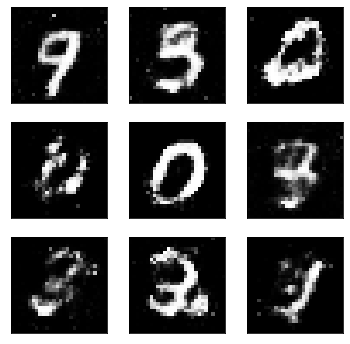

Don't worry if the results do not look perfect. Training GANs on colab is not easy. Your implementation is much more important.